In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
combined_stats = pd.read_csv('Data/FantasyFootballHealthProjections.csv')

### AvgSeasonGames- where applicable a 3 year average for veteran players, a two year average for recently drafted players, and for rookies how many games they played in the 2024 season.

### Criteria of the Dataset 
* HealthGrade = Basic Health Score (Based on Availability Only) for veterans, Case by Case basis for backups, and assuming 2025 Rookies will be healthy. 
* HealthStatus = 0 - Healthy/Healthy Backup (16-17 games or being a healthy backup), 1 - Minor Injuries (14-15 games), 2 - Moderate Injuries (10-13 games), 3 - Major Injuries (5-9 games), 4 - Significant Injuries (0-4 games).

In [7]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthStatus,2023HealthStatus2,2023SeriousInjury,2024Age,...,AvgSeasonGames,HealthGrade,2025Age,2025G,ModelProj.2025Games,PlayMoreThan14(AvgSeason),PredictedPlayMoreThan14,AdjustedRisk,RiskTier,Scale
0,6,Lamar Jackson,BAL,QB,26,16.0,0,Healthy,0,27,...,15.0,88,28,17,17,1,1,0,Low,"1=Yes, 0=No"
1,21,Ja'Marr Chase,CIN,WR/TE,23,16.0,0,Healthy,0,24,...,15.0,88,25,17,16,1,1,0,Low,NaN
2,1,Josh Allen,BUF,QB,27,17.0,0,Healthy,0,28,...,17.0,100,29,16,17,1,1,0,Low,NaN
3,11,Joe Burrow,CIN,QB,27,10.0,2,Moderate Injuries,0,28,...,14.0,82,29,17,17,0,0,3,Moderate,NaN
4,26,Baker Mayfield,TAM,QB,28,17.0,0,Healthy,0,29,...,15.0,88,30,17,17,1,1,0,Low,NaN


In [9]:
combined_stats.sort_values(by='HealthGrade', ascending=False).tail()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthStatus,2023HealthStatus2,2023SeriousInjury,2024Age,...,AvgSeasonGames,HealthGrade,2025Age,2025G,ModelProj.2025Games,PlayMoreThan14(AvgSeason),PredictedPlayMoreThan14,AdjustedRisk,RiskTier,Scale
247,210,Clyde Edwards-Helaire,NaN,RB,24,15.0,1,Minor Injuries,0,25,...,9.0,53,26,12,16,0,0,7,Significant,NaN
94,22,Anthony Richardson,NaN,QB,21,4.0,4,Significant Injuries,1,22,...,8.0,47,23,17,13,0,0,9,Significant,NaN
278,230,Rondale Moore,NaN,WR/TE,23,17.0,0,Healthy,0,24,...,8.0,47,25,17,17,0,0,6,Significant,NaN
191,99,Deshaun Watson,NaN,QB,28,6.0,3,Major Injuries,1,29,...,6.0,35,30,10,13,0,0,9,Significant,NaN
279,228,Elijah Mitchell,NaN,RB,25,11.0,2,Moderate Injuries,0,26,...,5.0,29,27,17,16,0,0,9,Significant,NaN


In [11]:
combined_stats.groupby('FantPos')['HealthGrade'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,88.578947,14.888108,35.0,82.0,94.0,100.0,100.0
RB,88.0,87.806818,12.867904,29.0,80.5,89.0,100.0,100.0
WR/TE,155.0,89.296774,11.334452,47.0,82.0,94.0,100.0,100.0


In [13]:
combined_stats.groupby('FantPos')['AvgSeasonGames'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,35.0,13.071429,3.817804,2.0,11.75,14.0,16.0,17.0
RB,76.0,14.282895,2.319965,5.0,13.00,15.0,16.0,17.0
WR/TE,145.0,14.841379,1.975284,8.0,14.00,15.0,16.0,17.0


In [15]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         281 non-null    int64  
 1   Player                     281 non-null    object 
 2   Tm                         92 non-null     object 
 3   FantPos                    281 non-null    object 
 4   2023Age                    281 non-null    int64  
 5   2023G                      220 non-null    float64
 6   2023HealthStatus           281 non-null    int64  
 7   2023HealthStatus2          281 non-null    object 
 8   2023SeriousInjury          281 non-null    int64  
 9   2024Age                    281 non-null    int64  
 10  2024G                      257 non-null    float64
 11  2024HealthStatus           281 non-null    int64  
 12  2024HealthStatus2          281 non-null    object 
 13  2024SeriousInjury          281 non-null    int64  

## Evaluate data using Train, Test, and Split with Random Forest Regression- HealthGrade

In [18]:
# Step 1: Function to train and predict for a specific position
# This function handles data filtering, model training, prediction, evaluation, and result formatting for a given NFL player position.
def train_and_predict(position, features):
    # Filters the dataset for a specific position, such as 'RB', 'WR/TE', or 'QB'.
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    # Uses .copy() to avoid modifying the original DataFrame.    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X (Predictor Variables) and y (Target Variable)
    X = position_data[features].fillna(0)
    y = position_data['HealthGrade'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    # Ensures that the training and test data are split before training.
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Train the model
    rf = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    # y_pred_train: Predictions the model makes on the training set (the data it saw during learning).
    # y_pred_test: Predictions on the test set (data it did not see during training).
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    # The resulting predictions are tagged as either 'Train' or 'Test'
    # train_df: Contains predictions for the training data — the model saw this during training.
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', 'HealthGrade']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'PredictedHealthGrade'] = y_pred_train
    # test_df: Contains predictions for the testing data — the model never saw this during training.
    test_df = position_data.loc[idx_test, ['Player', 'FantPos', 'HealthGrade']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'PredictedHealthGrade'] = y_pred_test
    # Take the model’s predictions for the training and test data, combine them into one table, and reset the index so it's clean 
    # and ready for further analysis with the feature sets.
    return pd.concat([train_df, test_df], ignore_index=True)

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict('RB', rb_features)
wrte_predictions = train_and_predict('WR/TE', wrte_features)
qb_predictions = train_and_predict('QB', qb_features)

# Step 4: Combine all predictions (only test/train predictions, no leakage)
# No information from the test set leaks into the training process or vice versa when combining these predictions.
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Step 5: Save to CSV
output_path = "Data/FootballProjectedHealthGrades.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'PredictedHealthGrade', 'HealthGrade']].to_csv(output_path, index=False)


RB - Training MAE: 1.27
RB - Testing MAE: 2.00

RB - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.490596
6    AvgSeasonGames    0.355839
2  2023HealthStatus    0.046132
1             2023G    0.044446
4             2024G    0.028560
0           2023Age    0.011843
3           2024Age    0.011827
7           2025Age    0.010757

WR/TE - Training MAE: 0.77
WR/TE - Testing MAE: 2.08

WR/TE - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.376490
6    AvgSeasonGames    0.355125
2  2023HealthStatus    0.110783
4             2024G    0.081078
1             2023G    0.037262
0           2023Age    0.019460
3           2024Age    0.010077
7           2025Age    0.009725

QB - Training MAE: 2.58
QB - Testing MAE: 3.71

QB - Feature Importances:
            Feature  Importance
2  2023HealthStatus    0.524601
6    AvgSeasonGames    0.135376
5  2024HealthStatus    0.132443
0           2023Age    0.050532
4             2024G    0.05017

* R²: Measures how well the model’s predictions match the real values — 1.0 is a perfect score, and 0.0 means the model performs no better than just predicting the mean.

* MAE: Gives the average difference between actual and predicted health grades — lower is better.


In [21]:
# Evaluate R² and MAE by position
# Start with an empty Python list
position_metrics = []
# test_only = all_predictions[all_predictions['Data Split'] == 'Test']
# train_only = all_predictions[all_predictions['Data Split'] == 'Train']

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})
    
# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Converting to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB  0.943  1.41
1    WR/TE  0.941  0.99
2       QB  0.917  2.76


In [23]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position (Test Data Only):")
print(position_metrics_df)


Health Metrics by Position (Test Data Only):
  Position     R²   MAE
0       RB  0.833  2.06
1    WR/TE  0.900  1.97
2       QB  0.086  3.62


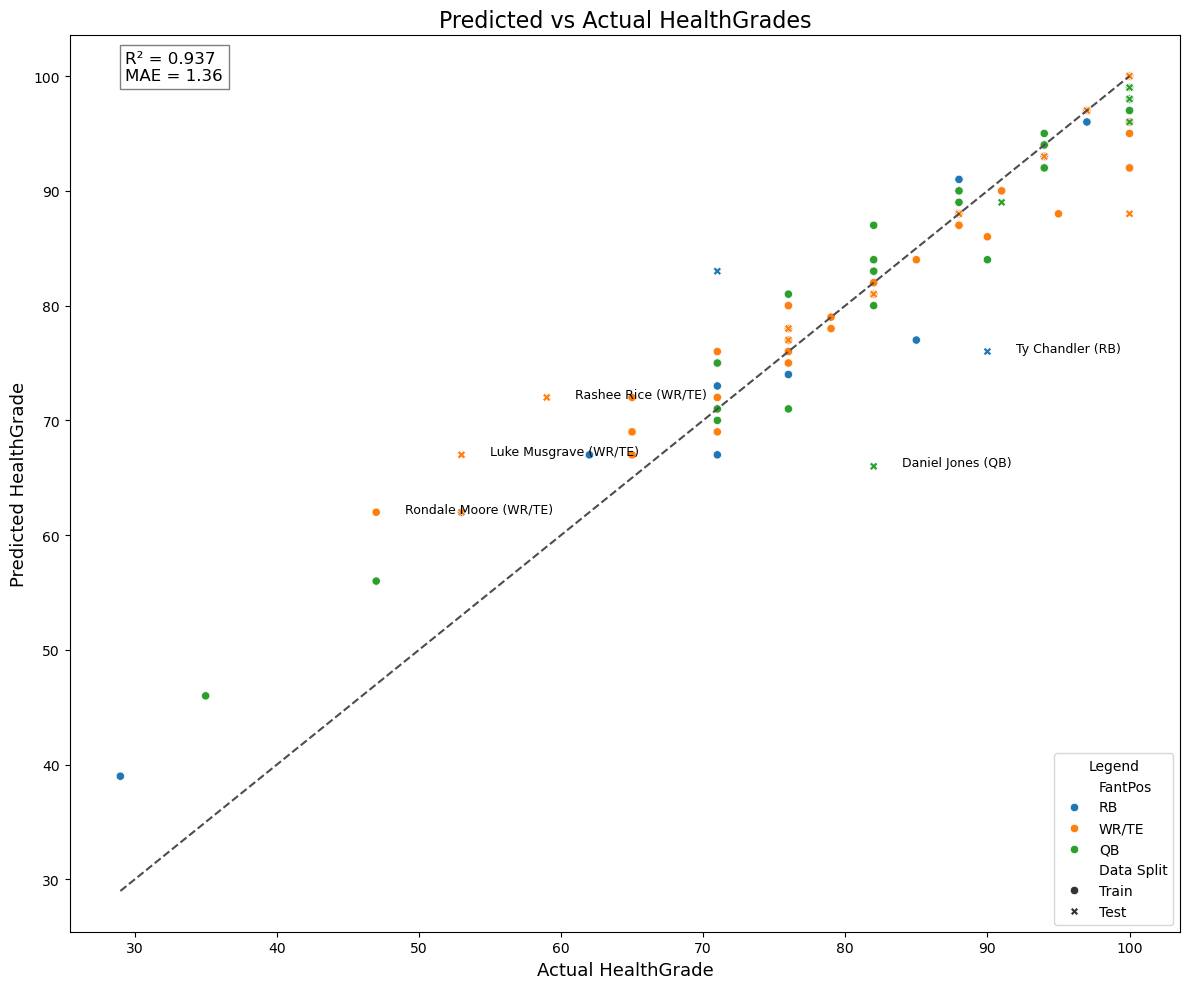

In [25]:
# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])
mae = mean_absolute_error(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['HealthGrade'] - all_predictions['PredictedHealthGrade'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=all_predictions,
    x='HealthGrade', y='PredictedHealthGrade',
    hue='FantPos', style='Data Split',
    palette='tab10'
)

# Diagonal line for the predictions
min_val = all_predictions['HealthGrade'].min()
max_val = all_predictions['HealthGrade'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['HealthGrade'] + 2, row['PredictedHealthGrade'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual HealthGrades', fontsize=16)
plt.xlabel('Actual HealthGrade', fontsize=13)
plt.ylabel('Predicted HealthGrade', fontsize=13)

# Get the current axes
ax = plt.gca()

# Show R² and MAE on the plot
plt.text(0.05, 0.95,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         transform=ax.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

## Evaluate data using with Random Forest Regression and Cross Validation- HealthGrade

Cross-validation (CV), especially k-fold cross-validation, allows you to:

* Test the model’s generalization ability:
     * Train the model on part of the data and test it on a separate fold.
     * This mimics real-world prediction where the model sees new players or new seasons.

* Get a more reliable performance estimate:
    * It smooths out performance variation that might occur from a lucky or unlucky split.

* Avoid data leakage and overfitting:
    * Each prediction is made on data the model hasn’t seen, so the reported performance is more honest.
      
* Cross-validation is a method to simulate real-world performance and reduce overfitting risk.

* The Random Forest Regression model’s performance on the training data shows how well it can fit the data it has seen, while 5-fold cross-validation evaluates how well the model generalizes to unseen data.

What 5-Fold Cross-Validation Does:

* It splits your full dataset into 5 equal-sized parts (called "folds").

* It runs 5 training/testing cycles — in each cycle:

* It uses 4 folds (80%) for training

* And 1 fold (20%) for testing

* Each fold gets to be the test set exactly once.

* It systematically rotates through the dataset so that every example is tested once and only once.

In [50]:

# Step 1: Cross-validation function
def train_and_predict_cv(position, features):
    # Filter data
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X(predictor variables) and y(target variable)
    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['HealthGrade'].fillna(0).reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)
    
    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Define model and CV splitter
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get cross-validated predictions
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Get cross-validation scores
    mae_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()

    print(f"\n{position} - Cross-Validated MAE: {mean_mae:.2f}")

    # Refit on full data for feature importances
    rf.fit(X, y)
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['PredictedHealthGrade'] = y_pred
    return position_data[['Player', 'FantPos', 'Data Split', 'PredictedHealthGrade', 'HealthGrade']]

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2023SeriousInjury', '2024SeriousInjury', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict_cv('RB', rb_features)
wrte_predictions = train_and_predict_cv('WR/TE', wrte_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Step 4: Combine and round
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Step 5: Save results
output_path = "Data/FootballProjectedHealthGrades_CV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'PredictedHealthGrade', 'HealthGrade']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 3.21

RB - Feature Importances:
             Feature  Importance
7   2024HealthStatus    0.477117
8     AvgSeasonGames    0.322996
2   2023HealthStatus    0.070929
1              2023G    0.054021
6              2024G    0.031280
4  2024SeriousInjury    0.013390
9            2025Age    0.011518
0            2023Age    0.008931
5            2024Age    0.007885
3  2023SeriousInjury    0.001935

WR/TE - Cross-Validated MAE: 1.86

WR/TE - Feature Importances:
             Feature  Importance
8     AvgSeasonGames    0.384131
7   2024HealthStatus    0.338672
2   2023HealthStatus    0.092647
6              2024G    0.068845
4  2024SeriousInjury    0.039601
1              2023G    0.037939
9            2025Age    0.012717
5            2024Age    0.012046
3  2023SeriousInjury    0.007710
0            2023Age    0.005692

QB - Cross-Validated MAE: 6.34

QB - Feature Importances:
             Feature  Importance
2   2023HealthStatus    0.285036
3  2023SeriousInjury    0

* R²: Measures how well the model’s predictions match the real values — 1.0 is a perfect score, and 0.0 means the model performs no better than just predicting the mean.

* MAE: Gives the average difference between actual and predicted health grades — lower is better.


In [53]:
# Evaluate R² and MAE by position for the full set and not each cross validation
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB  0.676  3.17
1    WR/TE  0.835  1.84
2       QB  0.581  6.37


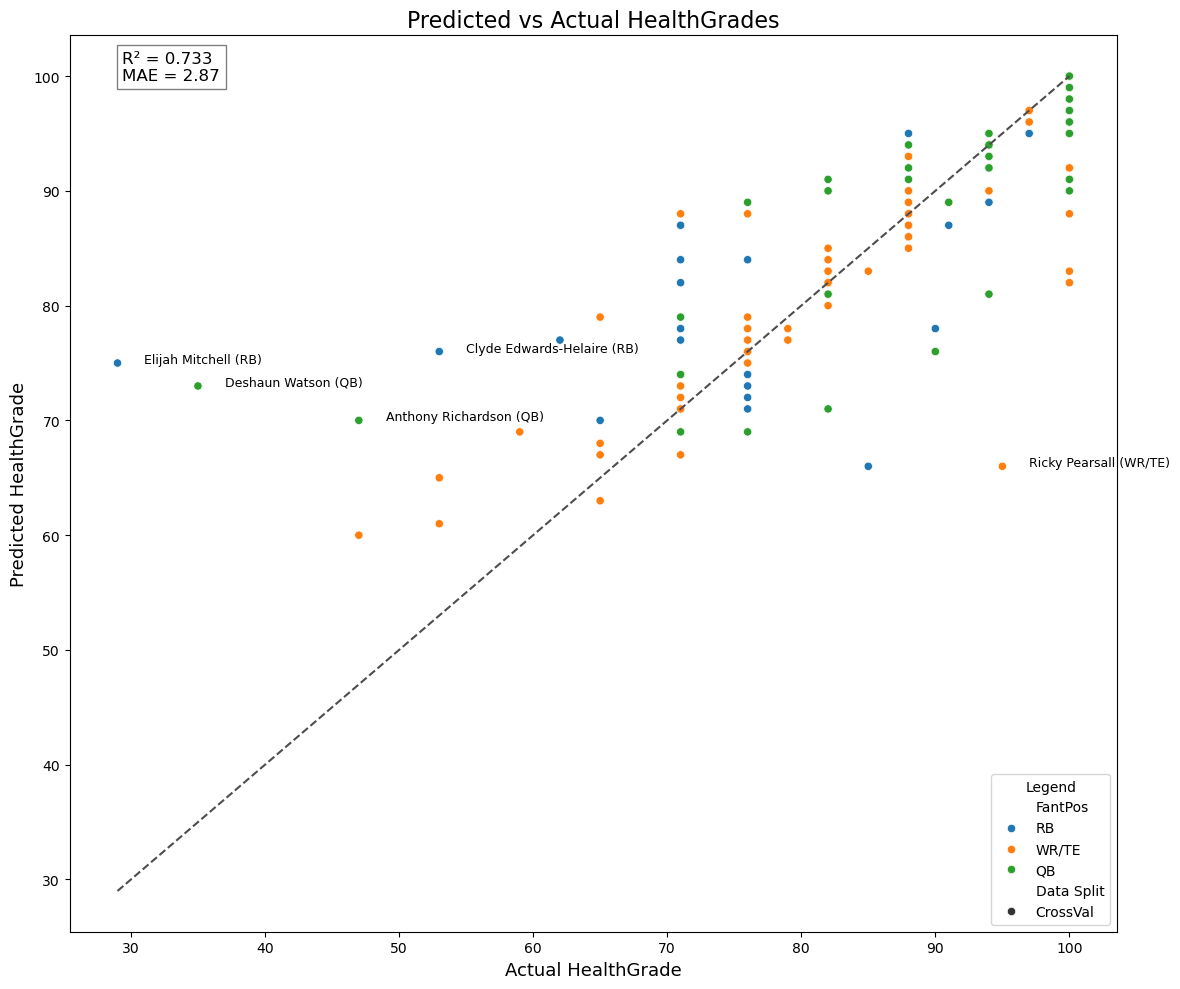

In [55]:
# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])
mae = mean_absolute_error(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['HealthGrade'] - all_predictions['PredictedHealthGrade'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=all_predictions,
    x='HealthGrade', y='PredictedHealthGrade',
    hue='FantPos', style='Data Split',
    palette='tab10'
)

# Diagonal line for the predictions
min_val = all_predictions['HealthGrade'].min()
max_val = all_predictions['HealthGrade'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['HealthGrade'] + 2, row['PredictedHealthGrade'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual HealthGrades', fontsize=16)
plt.xlabel('Actual HealthGrade', fontsize=13)
plt.ylabel('Predicted HealthGrade', fontsize=13)

# Get the current axes
ax = plt.gca()

# Show R² and MAE on the plot
plt.text(0.05, 0.95,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         transform=ax.transAxes,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

In [57]:
# Step 1: Calculate absolute error
all_predictions['AbsError'] = (all_predictions['PredictedHealthGrade'] - all_predictions['HealthGrade']).abs()

# Step 2: Sort by error
top_outliers = all_predictions.sort_values(by='AbsError', ascending=False).head(15)

# Step 3: Show relevant columns
print(top_outliers[['Player', 'FantPos', 'PredictedHealthGrade', 'HealthGrade', 'AbsError']])

                    Player FantPos  PredictedHealthGrade  HealthGrade  \
86         Elijah Mitchell      RB                  75.0           29   
32          Deshaun Watson      QB                  73.0           35   
100         Ricky Pearsall   WR/TE                  66.0           95   
70   Clyde Edwards-Helaire      RB                  76.0           53   
24      Anthony Richardson      QB                  70.0           47   
72          MarShawn Lloyd      RB                  66.0           85   
45              Ty Johnson      RB                  82.0          100   
108         Cedric Tillman   WR/TE                  82.0          100   
129          Tanner Hudson   WR/TE                  83.0          100   
115           Theo Johnson   WR/TE                  88.0           71   
28        Javonte Williams      RB                  87.0           71   
71         Keaton Mitchell      RB                  77.0           62   
89            Keon Coleman   WR/TE                 

## Evaluate data using Random Forest Regressor and Cross Validation- 2025G

In [86]:

# Step 1: Cross-validation function
def train_and_predict_games_cv(position, features):
    # Filter data
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X(predictor variables) and y(target variable)
    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['2025G'].fillna(0).reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Define model and CV splitter
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get cross-validated predictions
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Get cross-validation scores during the model training
    mae_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()

    print(f"\n{position} - Cross-Validated MAE: {mean_mae:.2f}")

    # Refit on full data for feature importances
    rf.fit(X, y)
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted2025G'] = y_pred
    return position_data[['Player', 'FantPos', 'Data Split', 'Predicted2025G', '2025G']]

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2023SeriousInjury', '2024SeriousInjury', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict_games_cv('RB', rb_features)
wrte_predictions = train_and_predict_games_cv('WR/TE', wrte_features)
qb_predictions = train_and_predict_games_cv('QB', qb_features)

# Step 4: Combine into one data frame and round
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Python dictionary
override_dict = {
    'Tank Dell': {'games': 0, 'note': 'Out for season'},
}

# Loop through the override dictionary and update the DataFrame for any matching players:
for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted2025G'] = override['games']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Step 4: Save results
output_path = "Data/FootballProjected2025G_CV.csv"
all_predictions.to_csv(output_path, index=False)


RB - Cross-Validated MAE: 1.16

RB - Feature Importances:
             Feature  Importance
6              2024G    0.232019
8     AvgSeasonGames    0.220652
1              2023G    0.142380
0            2023Age    0.139355
7   2024HealthStatus    0.078168
9            2025Age    0.073200
5            2024Age    0.068435
2   2023HealthStatus    0.028982
4  2024SeriousInjury    0.015748
3  2023SeriousInjury    0.001061

WR/TE - Cross-Validated MAE: 0.73

WR/TE - Feature Importances:
             Feature  Importance
6              2024G    0.248885
1              2023G    0.196991
7   2024HealthStatus    0.111307
5            2024Age    0.107147
8     AvgSeasonGames    0.088587
9            2025Age    0.085794
0            2023Age    0.083068
2   2023HealthStatus    0.056169
4  2024SeriousInjury    0.011102
3  2023SeriousInjury    0.010949

QB - Cross-Validated MAE: 1.44

QB - Feature Importances:
             Feature  Importance
8     AvgSeasonGames    0.211025
1              2023G    0

In [88]:
# Evaluate R² and MAE by position for the full set and not each cross validation
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025G'], subset['Predicted2025G'])
    mae = mean_absolute_error(subset['2025G'], subset['Predicted2025G'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB -0.276  1.14
1    WR/TE  0.266  0.61
2       QB -0.270  1.37


In [90]:
# Step 1: Calculate absolute error
all_predictions['AbsError'] = (all_predictions['Predicted2025G'] - all_predictions['2025G']).abs()

# Step 2: Sort by error
top_outliers = all_predictions.sort_values(by='AbsError', ascending=False).head(15)

# Step 3: Show relevant columns
print(top_outliers[['Player', 'FantPos', 'Predicted2025G', '2025G', 'AbsError']])

                 Player FantPos  Predicted2025G  2025G  AbsError
93     Christian Watson   WR/TE             9.0     17       8.0
31            Drew Lock      QB            17.0     10       7.0
142       Luke Musgrave   WR/TE            10.0     17       7.0
20         Kirk Cousins      QB            17.0     10       7.0
27           Will Levis      QB            16.0     10       6.0
69        Carson Steele      RB            17.0     12       5.0
72       MarShawn Lloyd      RB            17.0     12       5.0
87        Chase Edmonds      RB            17.0     12       5.0
28         Dak Prescott      QB            12.0     17       5.0
30   Alexander Mattison      RB            17.0     12       5.0
61      Jamaal Williams      RB            17.0     12       5.0
65          Zamir White      RB            16.0     12       4.0
67          Ty Chandler      RB            16.0     12       4.0
25     Jameson Williams   WR/TE            13.0     17       4.0
54      Ezekiel Elliott  

## Evaluate data using Random Forest Classification and Cross Validation to determine a Binary Target for a new column called 'PlayMoreThan14'.

In [96]:

# Step 1: Create binary target variable — will play >14 games in 2025
combined_stats['PlayMoreThan14'] = (combined_stats['AvgSeasonGames'] > 14).astype(int)

# Step 2: Compute Injury Risk Score (0–5)
combined_stats['InjuryRiskScore'] = combined_stats['2023HealthStatus'] + combined_stats['2024HealthStatus']

# Step 3: Adjust risk score by adding modifiers
combined_stats['AdjustedRisk'] = (
     combined_stats['InjuryRiskScore'] +
    (combined_stats['2025Age'] > 30).astype(int) +
    (combined_stats['HealthGrade'] < 80).astype(int)
)

# Step 4: Assign Risk Tier
def assign_risk_tier(score):
    if score <= 1:
        return 'Low'
    elif score <= 2:
        return 'Minor'
    elif score <= 3:
        return 'Moderate'
    elif score <= 5:
        return 'High'
    else:
        return 'Significant'

combined_stats['RiskTier'] = combined_stats['AdjustedRisk'].apply(assign_risk_tier)

# Step 5: Train classifier per position
def train_classification_model(position, features):
    data = combined_stats[combined_stats['FantPos'] == position].copy()
    if data.empty:
        print(f"No data for position: {position}")
        return pd.DataFrame()
# Prepare X (Predictor Variables) and y (Target Variable)
    X = data[features].fillna(0)
    y = data['PlayMoreThan14']

    n_samples = len(data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Cross-validated predictions
    predictions = cross_val_predict(clf, X, y, cv=kf)

    # Accuracy metrics
    acc = accuracy_score(y, predictions)
    print(f"\n{position} - Accuracy: {acc:.3f}")
    print(classification_report(y, predictions))

    # Fit on full data and return predictions
    clf.fit(X, y)
    data['PredictedPlayMoreThan14'] = predictions

    return data[['Player', 'FantPos', 'PlayMoreThan14', 'PredictedPlayMoreThan14', 'AdjustedRisk', 'RiskTier']]

# Step 6: Define shared features
base_features = ['2023Age', '2023G', '2023HealthStatus', '2023SeriousInjury', '2024Age', '2024G', '2024HealthStatus', '2024SeriousInjury', '2025Age']

# Step 7: Run for each position
rb_results = train_classification_model('RB', base_features)
wrte_results = train_classification_model('WR/TE', base_features)
# te_results = train_classification_model('TE', base_features)
qb_results = train_classification_model('QB', base_features)

# Step 8: Combine into one data frame and export
all_classification_results = pd.concat([rb_results, wrte_results, qb_results])

# This dictionary contains manual override values for a player
override_dict = {
    'Tank Dell': {
        'PlayMoreThan14': 0,  # Not expected to play >14 games
        'PredictedPlayMoreThan14': 0,
        'AdjustedRisk': 5,
        'RiskTier': 'Significant'
    }
}
# Loop through each player and their override values in the dictionary
for player, override in override_dict.items():
# Loop through each column (key) and the value you want to override
    for col, val in override.items():
        all_classification_results.loc[all_classification_results['Player'] == player, col] = val
# Update the DataFrame:, For the row where 'Player' == Tank Dell, and set the column `col` to the value `val`.
        
all_classification_results.to_csv("Data/Football_Injury_Classification_Results.csv", index=False)


RB - Accuracy: 0.830
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        47
           1       0.81      0.83      0.82        41

    accuracy                           0.83        88
   macro avg       0.83      0.83      0.83        88
weighted avg       0.83      0.83      0.83        88


WR/TE - Accuracy: 0.903
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        60
           1       0.91      0.94      0.92        95

    accuracy                           0.90       155
   macro avg       0.90      0.89      0.90       155
weighted avg       0.90      0.90      0.90       155


QB - Accuracy: 0.842
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        23
           1       0.85      0.73      0.79        15

    accuracy                           0.84        38
   macro avg       0.84      0.82      0.83        38
weigh

### The Accuracy Scoring Explained:

The binary target:

0 = Will not play more than 14 games
1 = Will play more than 14 games

Precision Score: Of all the players the model predicted would play more than 14 games, how many actually did?
High precision means few false positives (model doesn't wrongly assume someone will play a full season).
"How trustworthy are the model’s positive predictions?"
High precision means it rarely makes false promises.

Recall Score: Of all the players who actually played more than 14 games, how many did the model correctly catch?
Why it matters:
High recall means few false negatives (model isn’t missing healthy players).
High recall means we’re not missing players who stayed healthy.
"How many real positives did the model successfully find?"

F1-score: Balance between precision & recall. A single score that balances both precision and recall.
Gives a better sense of model quality when class distribution is imbalanced.
If precision is high and recall is low, F1 helps give us a balanced view of overall quality

Support: Number of true instances for each class. The number of actual examples for each class

Macro Average: The average of precision, recall, and F1 treating both classes equally, regardless of size.

Weighted Average: Same metrics as macro, but each class is weighted by how many players it has and is more reflective of overall performance across the full dataset.


### Chart the Accuracy Scores

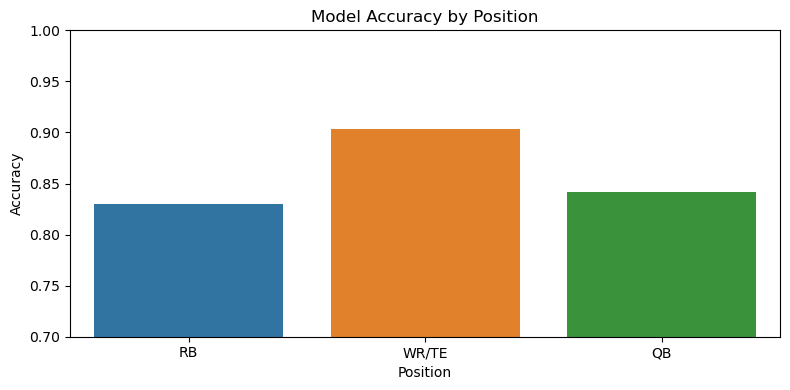

In [80]:
# Accuracy per position
accuracy_data = pd.DataFrame({
    'Position': ['RB', 'WR/TE', 'QB'],
    'Accuracy': [0.830, 0.903, 0.842]
})

# F1-scores per class (0 = did NOT play >14 games, 1 = did)
f1_data = pd.DataFrame({
    'Position': ['RB', 'RB', 'WR/TE', 'WR/TE', 'QB', 'QB'],
    'Class': ['0', '1', '0', '1', '0', '1'],
    'F1-Score': [0.84, 0.82, 0.87, 0.92, 0.88, 0.79]
})

plt.figure(figsize=(8, 4))
sns.barplot(data=accuracy_data, x='Position', y='Accuracy', hue='Position', legend=False)
plt.ylim(0.7, 1.0)
plt.title('Model Accuracy by Position')
plt.ylabel('Accuracy')
plt.xlabel('Position')
plt.tight_layout()
plt.show()

### Confusion Matrix for the Quaterbacks:

|                 | Predicted: No (0) | Predicted: Yes (1) |
|-----------------|------------------|---------------------|
| **Actual: No (0)** | True Negative = 22   | False Positive = 1   |
| **Actual: Yes (1)**| False Negative = 4   | True Positive = 11   |

### Doing a deep dive on the QB Accuracy Scores
- Class: Will Not Play >14 Games (0)
Precision: 0.85 → Of those predicted to not play >14, 85% were correct.

Recall: 0.96 → Of those who truly didn't play >14, 96% were caught.

F1-score: 0.90 → Strong balance of precision & recall.

- Class: Will Play >14 Games (1)
Precision: 0.92 → Of those predicted to play >14, 92% were correct.

Recall: 0.73 → Model only caught 73% of the true positives.

F1-score: 0.81 → Solid, but affected by lower recall.

- Averages Section:
Macro Avg (treats both classes equally):

Precision: 0.88

Recall: 0.84

F1-score: 0.86

Weighted Avg (accounts for more players in class 0):

Precision: 0.87

Recall: 0.87

F1-score: 0.87